In [2]:
import numpy as np
from pandas import DataFrame
import pandas as pd
import glob
import sys

sys.path.insert(0,'../../../../utils/python')

import readBinary
from utils import *
%pylab inline

import os


Populating the interactive namespace from numpy and matplotlib


In [9]:
def readBinary(dirname,varToLoad=None):
    print 'loading : ' + dirname
    df = dict()
    data=dict()

    varType=dict()

    for line in open(dirname+'/metadata.txt'):
        words=line.split()
        if words[0] == 'chunkSize' or words[0] == 'nVar' : continue
        varType[words[0]] = words[2][0] + words[1]

    for file in os.listdir(dirname):
        if ( varToLoad is not None and file.startswith(varToLoad)) or ( varToLoad is None and not file.endswith("metadata.txt") ):
            var=file.split('_chunk')[0]
            data[var] = np.fromfile(dirname+'/'+file, np.dtype(varType[var]))

    df = DataFrame(data)

    return df

In [10]:
def loadBinaryOld(dirname,varToLoad=None):
    print 'loading : '
    print dirname
    data=dict()
    for file in os.listdir(dirname):
        if file.startswith(varToLoad):
            data[file.split('_chunk')[0]] = np.fromfile(dirname+'/'+file, np.dtype('float32'))

    df = DataFrame(data)
    col=[]
    for c in df.columns:
        for v in newCol:
            if c.startswith(v[0]):
                col.append( c.replace(v[0],v[1]) )

    if len(col) != len(df.columns):
        print 'wrong df.columns size !\nExit !'
        sys.exit()
    df.columns=col
    return df

def makeDataframe(files, name, varToLoad, oldLoading=False):
    if oldLoading:
        loadFunction = loadBinaryOld
    else :
        loadFunction = readBinary

    df = pd.concat(map(lambda f: loadFunction(f,varToLoad), files[:150]))
    df = df[(df.Time_L0 > -999) & (df.Time_L1 > -999) & (df.Time_L2 > -999) & (df.Time_L3 > -999) & (df.R < 30) & (df.R > 1) & (df.BetaTOFH > 0.5) & (df.BetaTOFH < 1.2) & (df.NTofClustersHUsed == 4)]
    df['binRgdt'] = df['R'].astype('int')
    df.index.name = name
    return df

varToLoadNew=('Time_L','R','BetaTOF','NTofClustersHUsed')
varToLoadOld=('time_L','R','beta','NTofClusterH')

newCol=zip(varToLoadOld,varToLoadNew)

#dfMC = makeDataframe( glob.glob('/afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/smearingMinus30/*.00000001.output'), "MC", varToLoadNew)
#dfData = makeDataframe( glob.glob('/afs/cern.ch/user/b/bcoste/myeos/dstTofTiming/protons.B1034_pr.pl1.1200.qgsp_bic_ams/*.00000001.output'),  "MC",varToLoadOld,oldLoading=True)
dfMC = makeDataframe( glob.glob('/afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/protons.B1034_pr.pl1.1200.qgsp_bic_ams_noSmearing/*.00000001.output'), "MC", varToLoadNew)
dfData = makeDataframe( glob.glob('/afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/smearingMinus50/*.00000001.output'), "Data", varToLoadNew)

#dfData = makeDataframe( glob.glob('/afs/cern.ch/user/b/bcoste/myeos/dstTofTiming/ISS.B950_pass6/*.00000001.output'), "Data" , varToLoad , oldLoading=True)


    

loading : /afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/protons.B1034_pr.pl1.1200.qgsp_bic_ams_noSmearing/1946159363.00000001.output
loading : /afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/protons.B1034_pr.pl1.1200.qgsp_bic_ams_noSmearing/1946159364.00000001.output
loading : /afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/protons.B1034_pr.pl1.1200.qgsp_bic_ams_noSmearing/872731547.00000001.output
loading : /afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/protons.B1034_pr.pl1.1200.qgsp_bic_ams_noSmearing/872731548.00000001.output
loading : /afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/protons.B1034_pr.pl1.1200.qgsp_bic_ams_noSmearing/872731549.00000001.output
loading : /afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/protons.B1034_pr.pl1.1200.qgsp_bic_ams_noSmearing/872731550.00000001.output
loading : /afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/protons.B1034_pr.pl1.1200.qgsp_bic_ams_noSmearing/872731551.00000001.output
loading : /afs/cern.ch/user/b/bcoste/myeos/binaryAmsData/protons.B1

In [11]:
import sys

import bigQueryPlotting as bq
import math

def binning(df,var,nBins,firstBin,lastBin):
    binWidth=(lastBin-firstBin)/nBins
    return firstBin + binWidth * (df[var]-firstBin).floordiv(binWidth)

def plotDataFrame2D(df,nBinsX,firstBinX,lastBinX,nBinsY,firstBinY,lastBinY,varX,varY):
    binX='bin_'+varX
    binY='bin_'+varY
    dfTmp=pd.DataFrame(df[[varX,varY]])
    dfTmp[binX]=binning(dfTmp,varX,nBinsX,firstBinX,lastBinX)
    dfTmp[binY]=binning(dfTmp,varY,nBinsY,firstBinY,lastBinY)
    dfTmp=dfTmp[(dfTmp[binX] >= firstBinX) & (dfTmp[binX] < lastBinX) & (dfTmp[binY] >= firstBinY) & (dfTmp[binY] < lastBinY) ]
    plot_matrix( dfTmp.groupby([binY,binX]).count()[varX].unstack().fillna(0) )

for df in [dfData,dfMC]:
    print df.index.name
    df['invBetaH']=1/df.BetaTOFH
    df['Time_L3-Time_L0']=df['Time_L3']-df['Time_L0']
    df['Time_L1-Time_L0']=df['Time_L1']-df['Time_L0']
    df['Time_L3-Time_L1']=df['Time_L3']-df['Time_L1']
    df['Time_L3-Time_L2']=df['Time_L3']-df['Time_L2']




Data
MC


In [12]:
def makeHistAndFit(data,init,hist_range,ylimit,widthSecondFit,funcFit=None,**kwargs):
    if funcFit is None: funcFit=gaussian
    if len(data):
        n, bins, patches = plt.hist(data,normed=True,range=hist_range,bins=100,histtype='step',linewidth=2.0,**kwargs)
        ylim(ylimit)
        xdata, ydata = ((bins[:-1] + bins[1:])*0.5,n)
        out = fit(funcFit,xdata,ydata,init)
        if len(out[0]) > 2:
            x,y = zip(*filter(lambda x: -out[0][2]*widthSecondFit < x[0]-out[0][1] < out[0][2]*widthSecondFit,zip(xdata,ydata)))
            out = fit(funcFit,x,y,out[0])
            plt.plot(x,funcFit(out[0],x),linewidth=2.0)
        else : plt.plot(xdata,funcFit(out[0],xdata),linewidth=2.0)
        return out[0]
    return (-1,-1)

def fitAllRigBin(data,var,rigBins,init,hist_range,ylimit,widthSecondFit,**kwargs):
    par = []
    for i in range(len(rigBins[:-1])):
        name=var + 'distribution - rigidity : ['+str(rigBins[i])+','+str(rigBins[i+1])+']'
        figure(name)
        title(name)
        par.append( makeHistAndFit( df[(df['R']>=rigBins[i]) & (df['R']<rigBins[i+1])][var].values, init, hist_range,ylimit,widthSecondFit,**kwargs) )
    return par




### betaH distributions

[  2.           2.69230769   3.38461538   4.07692308   4.76923077
   5.46153846   6.15384615   6.84615385   7.53846154   8.23076923
   8.92307692   9.61538462  10.30769231  11.          11.69230769
  12.38461538  13.07692308  13.76923077  14.46153846  15.15384615
  15.84615385  16.53846154  17.23076923  17.92307692  18.61538462
  19.30769231  20.          20.69230769  21.38461538  22.07692308
  22.76923077  23.46153846  24.15384615  24.84615385  25.53846154
  26.23076923  26.92307692  27.61538462  28.30769231  29.        ]


/afs/cern.ch/user/b/bcoste/.virtualenvs/python-2.7-sql/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


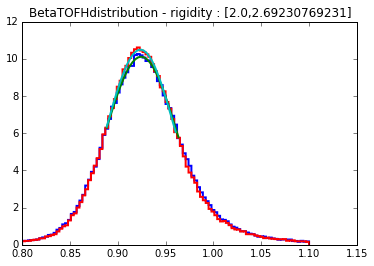

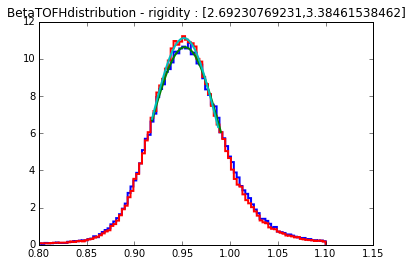

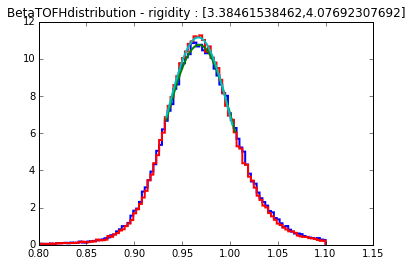

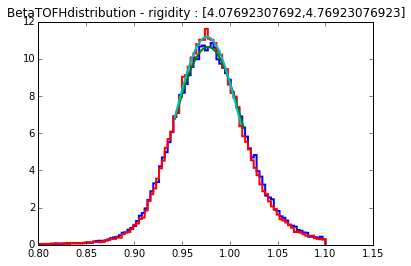

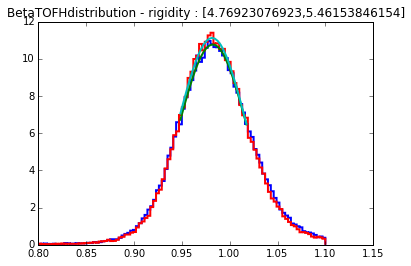

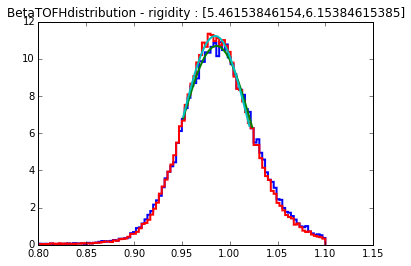

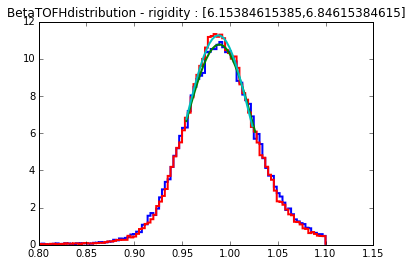

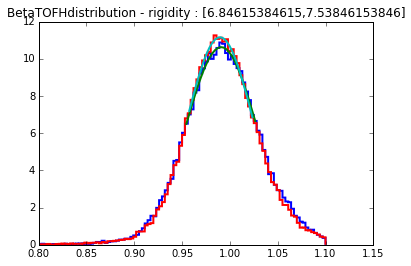

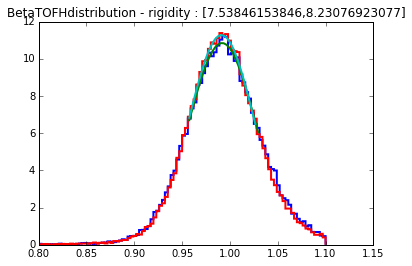

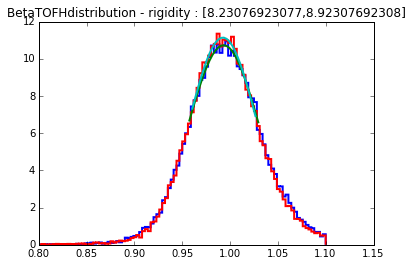

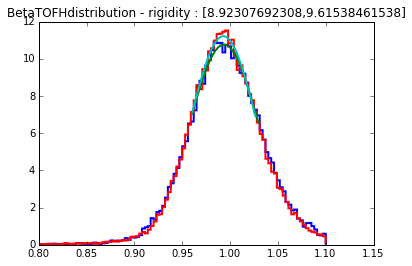

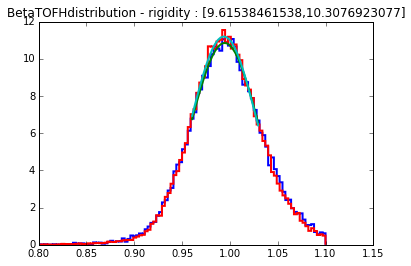

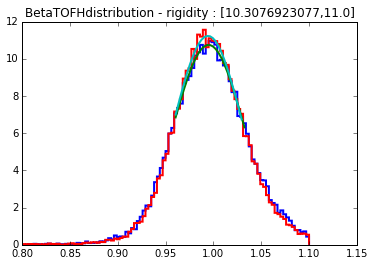

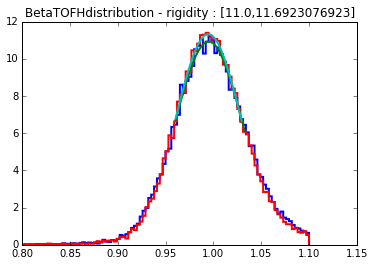

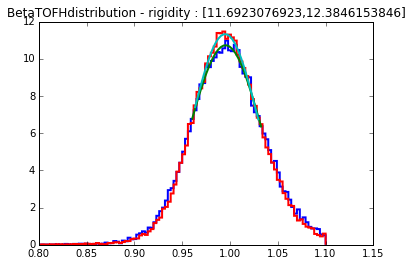

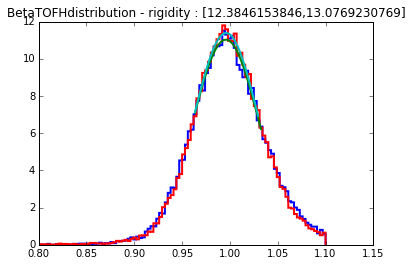

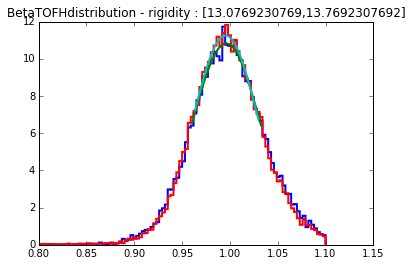

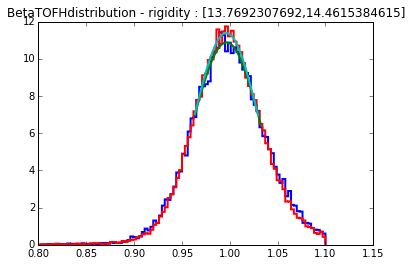

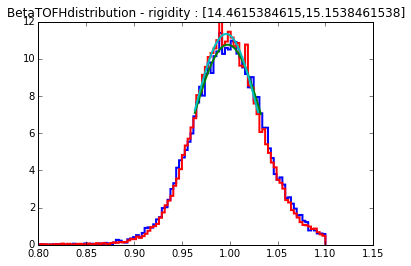

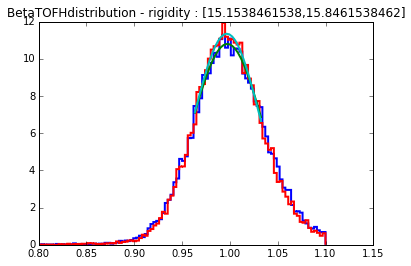

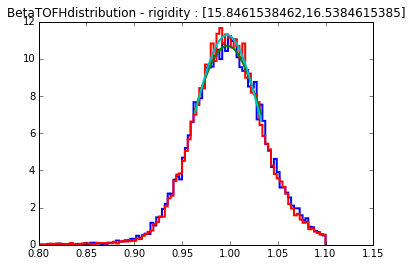

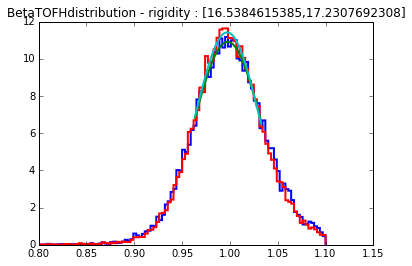

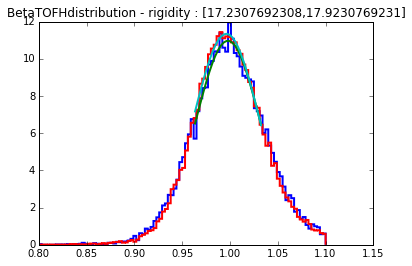

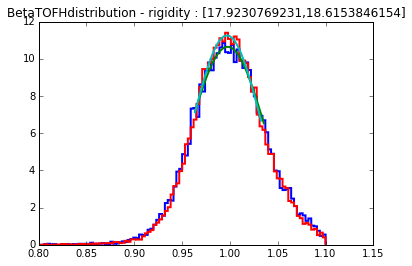

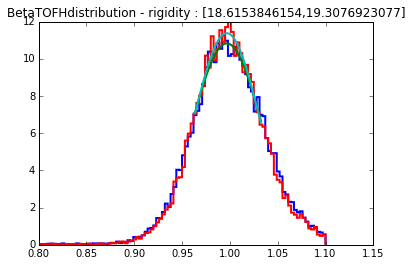

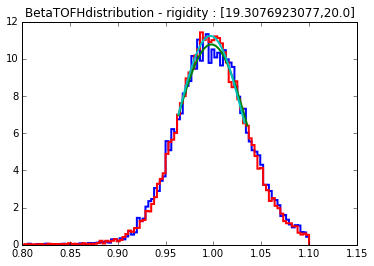

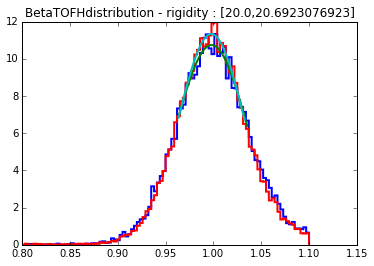

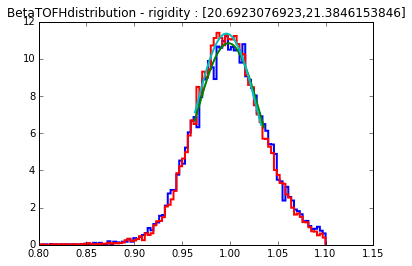

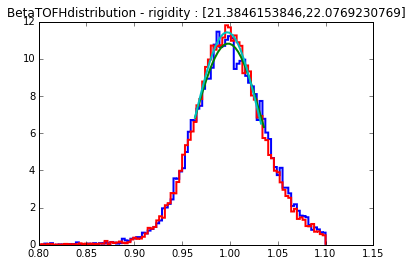

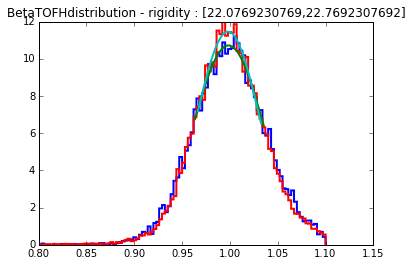

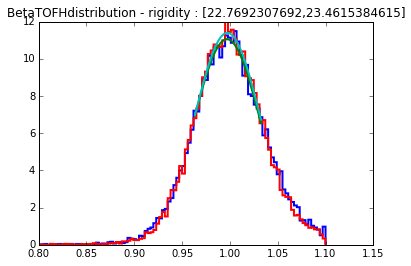

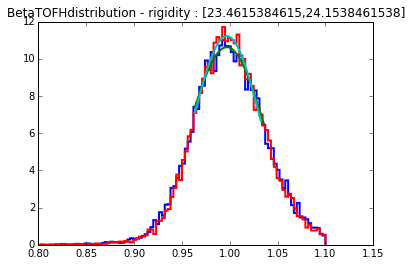

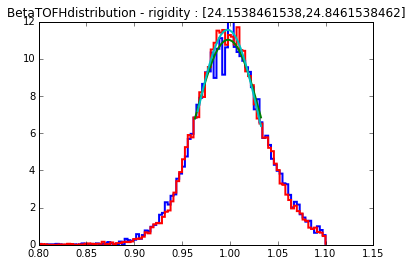

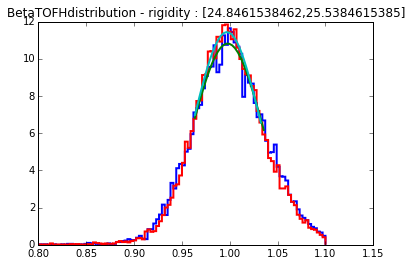

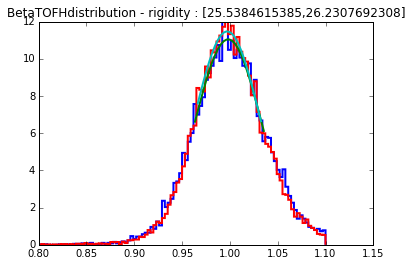

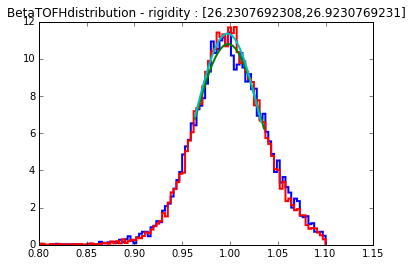

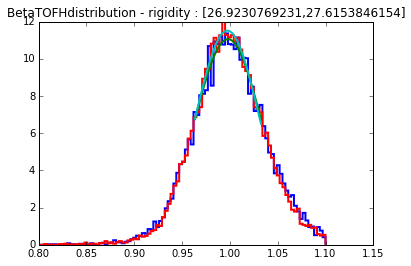

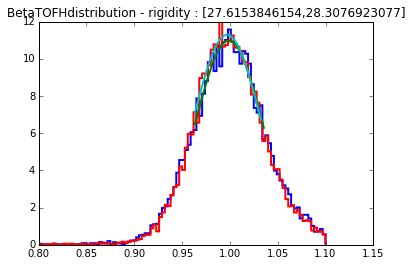

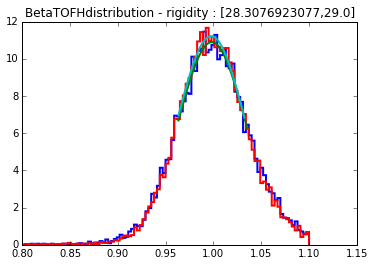

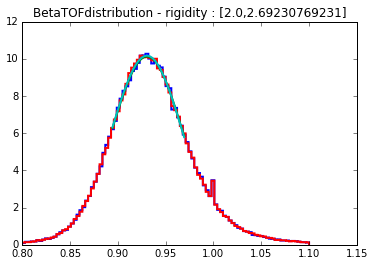

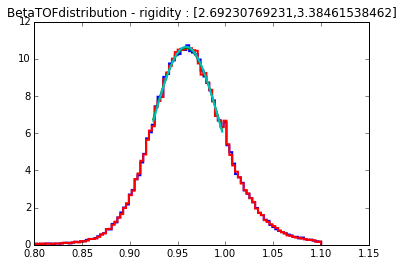

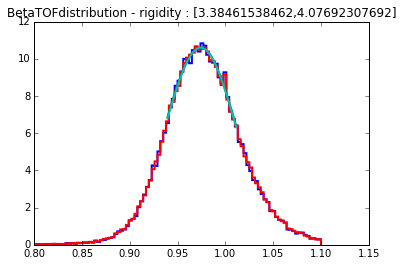

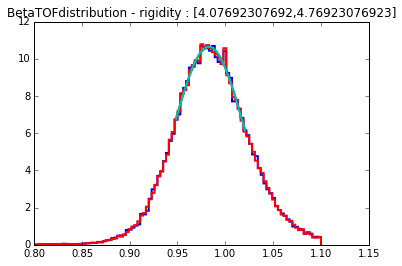

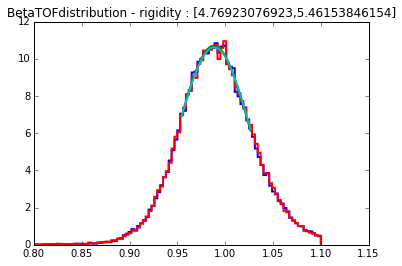

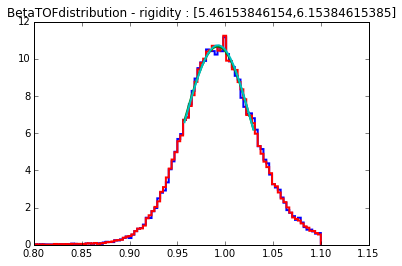

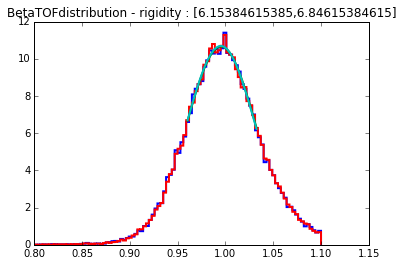

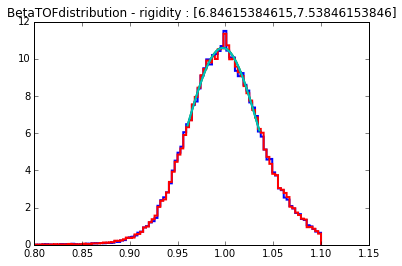

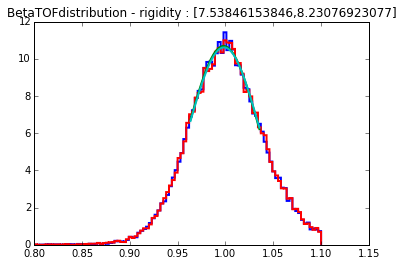

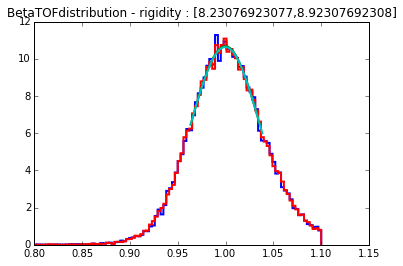

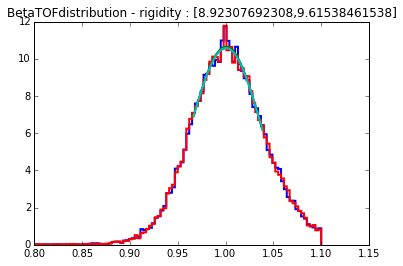

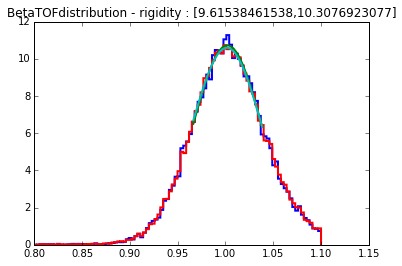

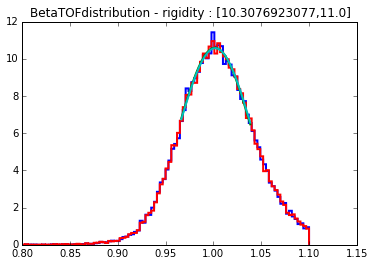

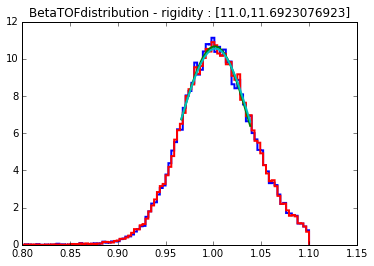

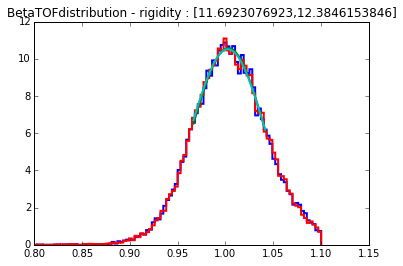

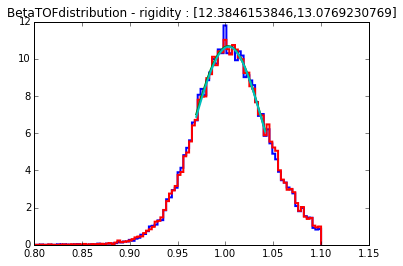

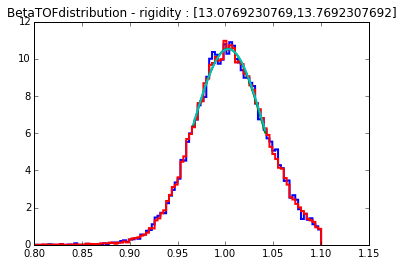

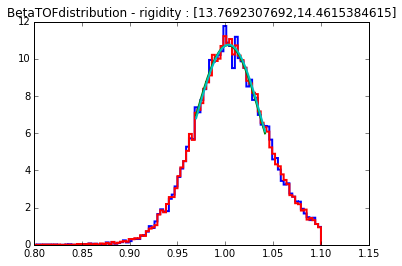

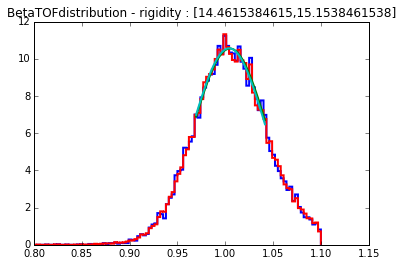

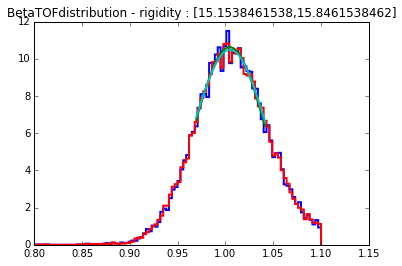

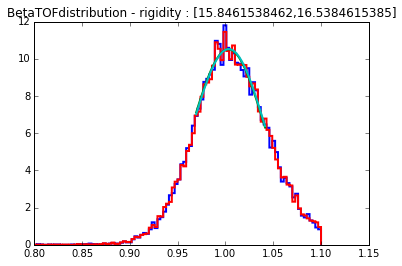

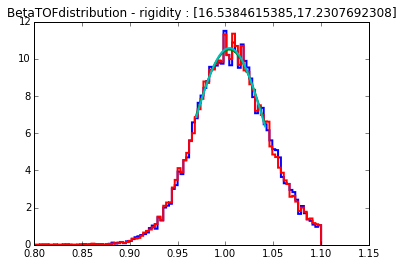

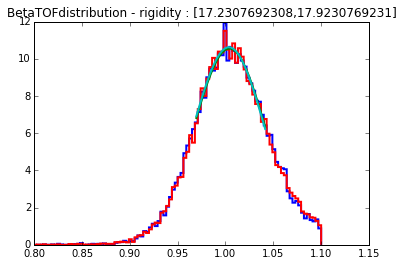

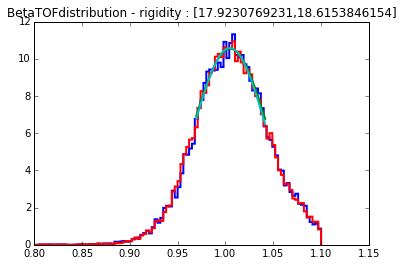

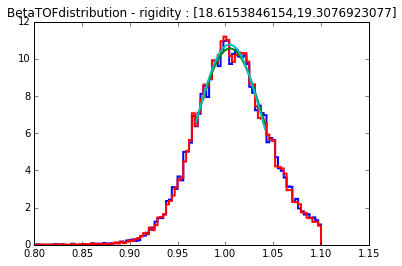

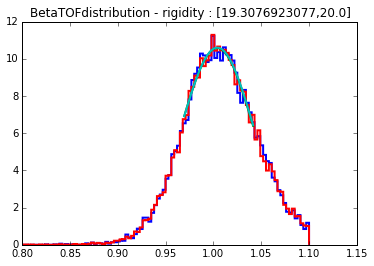

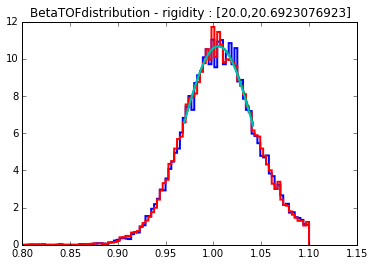

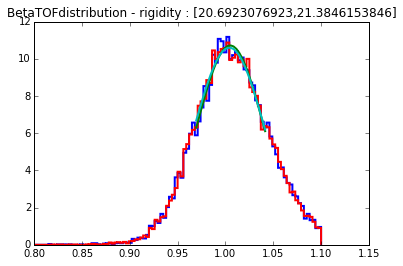

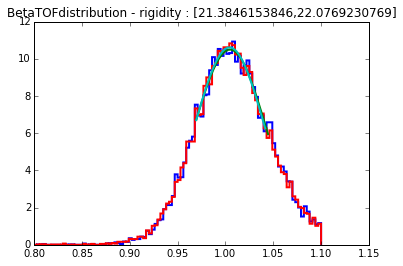

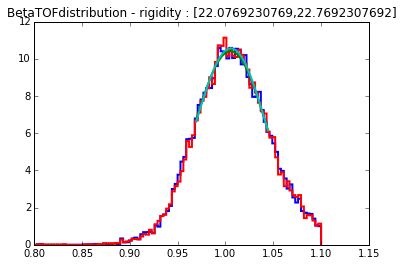

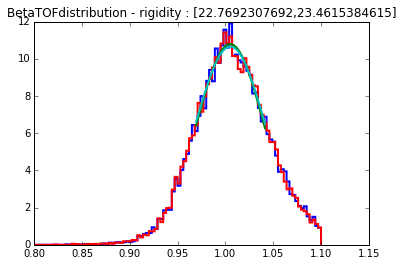

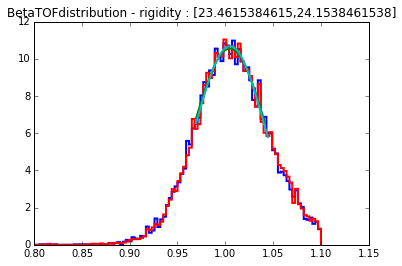

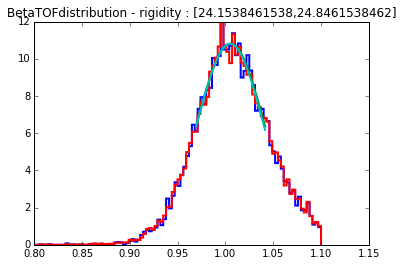

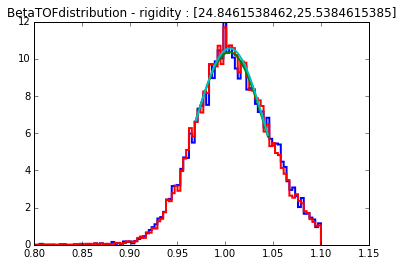

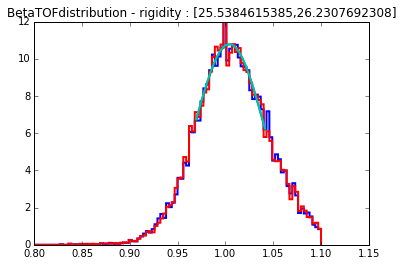

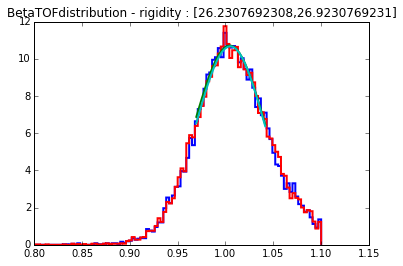

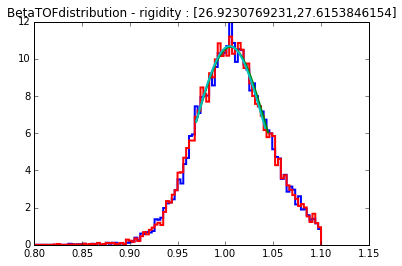

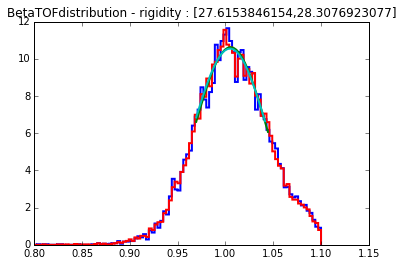

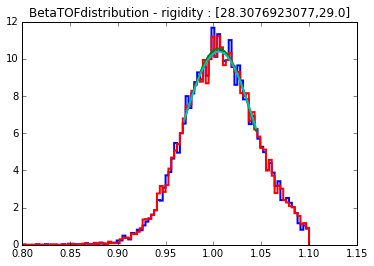

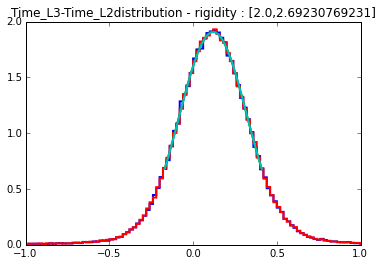

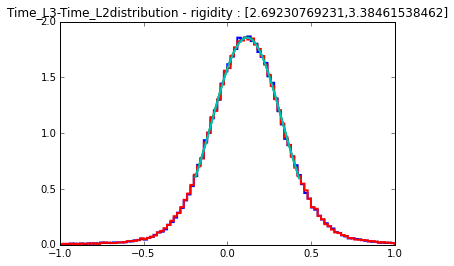

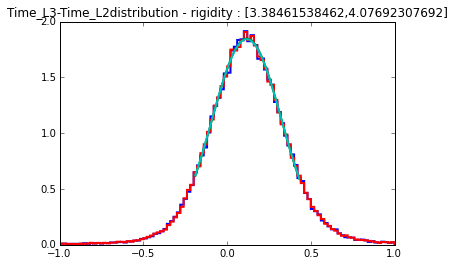

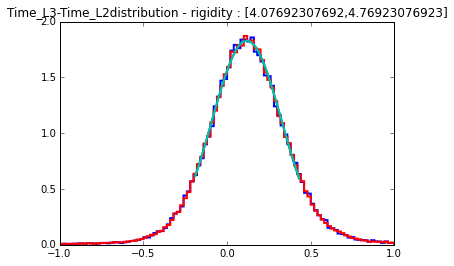

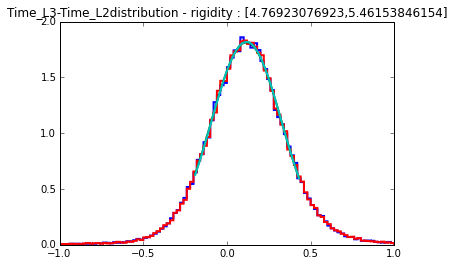

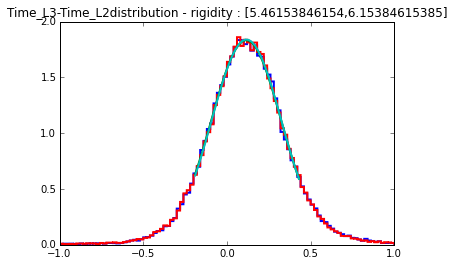

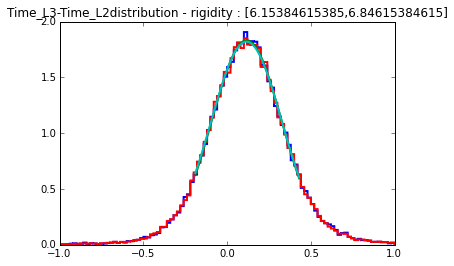

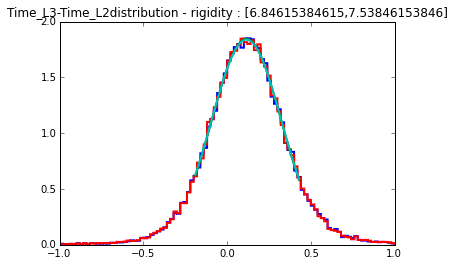

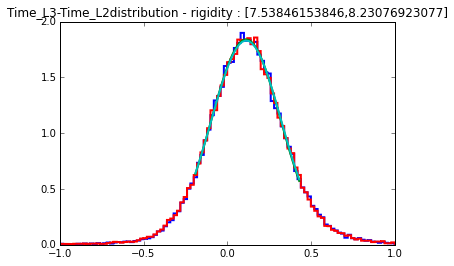

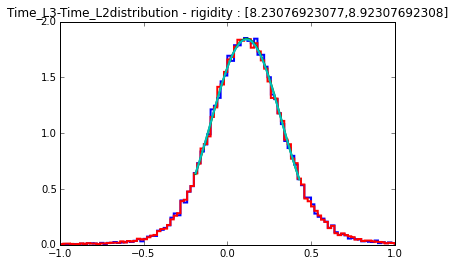

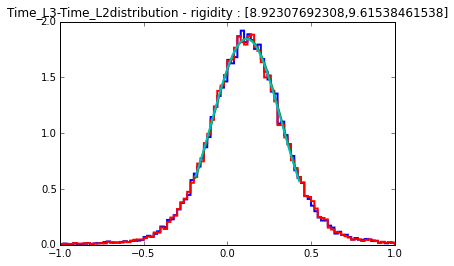

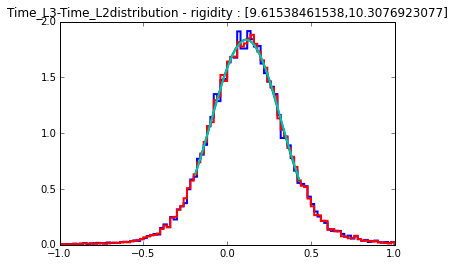

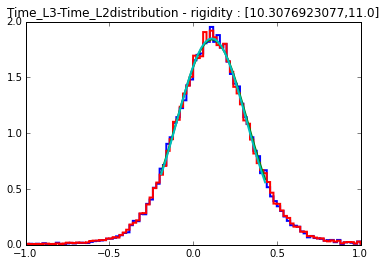

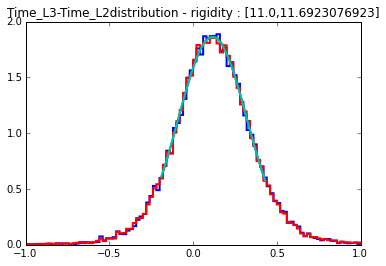

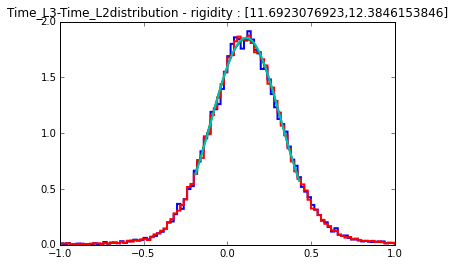

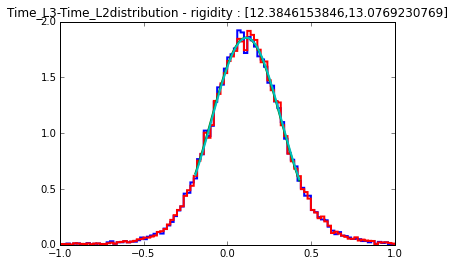

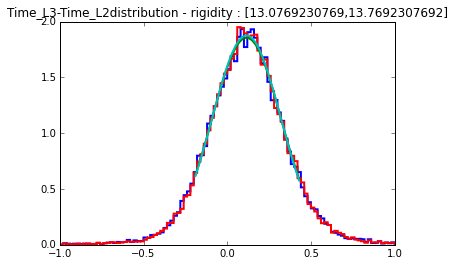

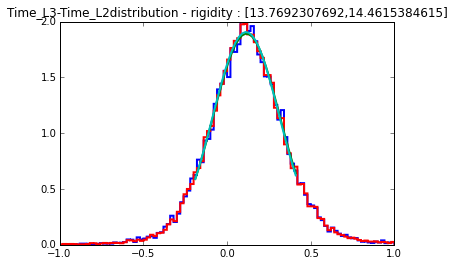

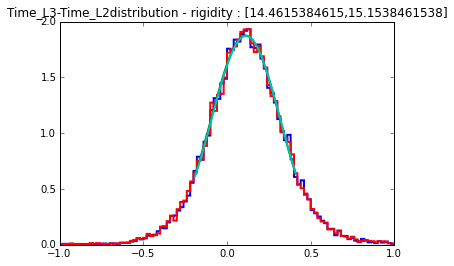

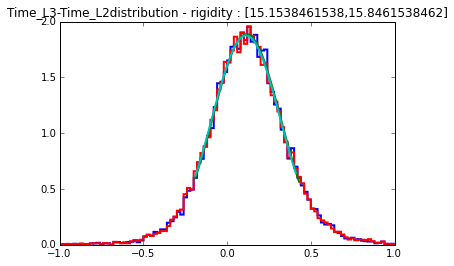

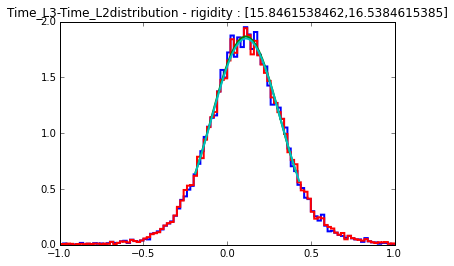

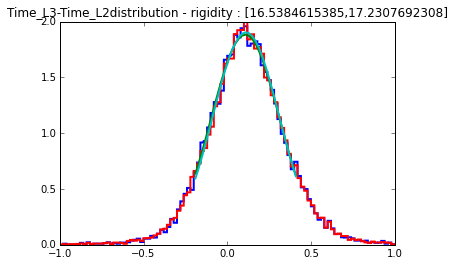

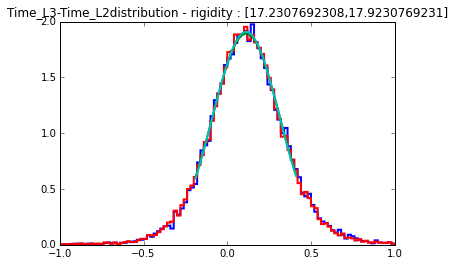

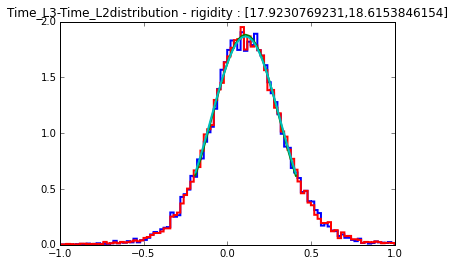

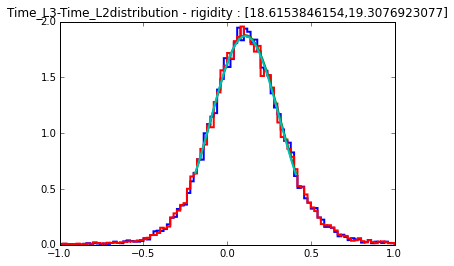

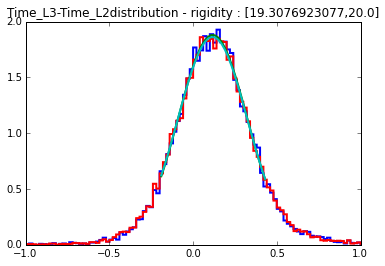

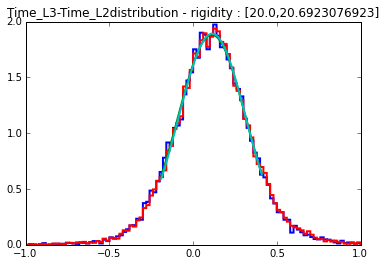

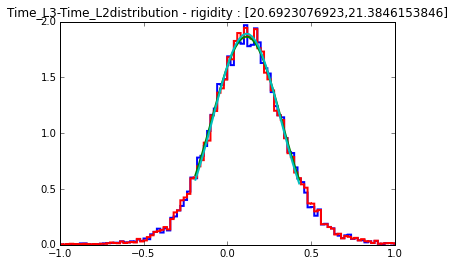

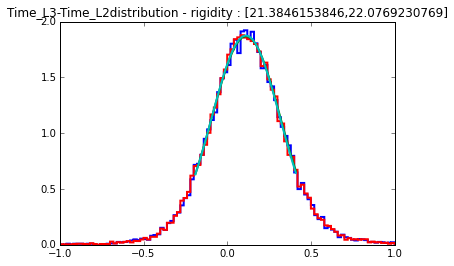

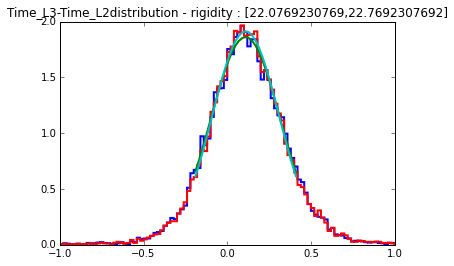

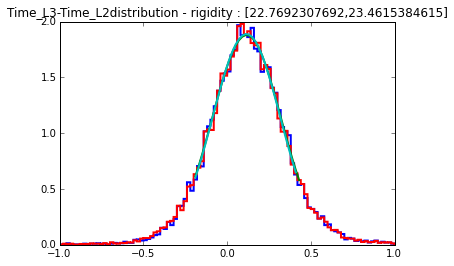

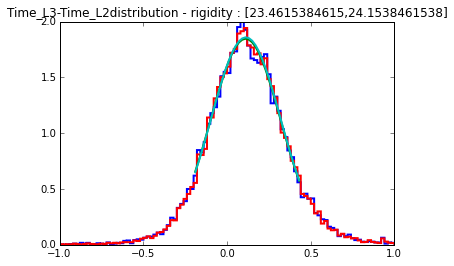

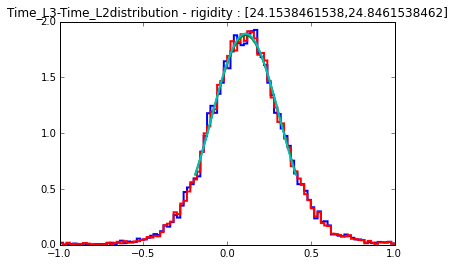

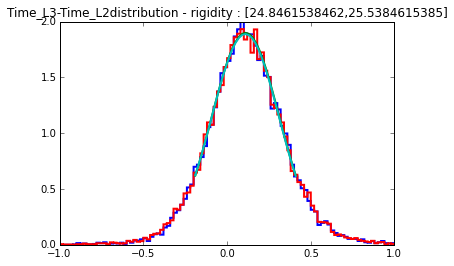

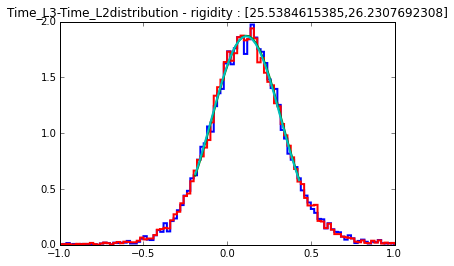

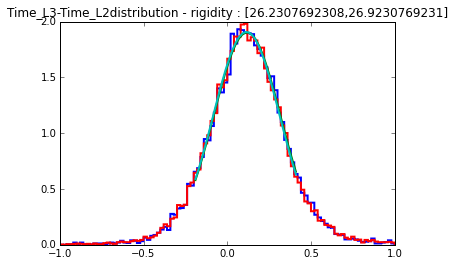

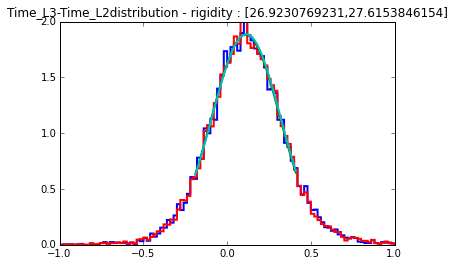

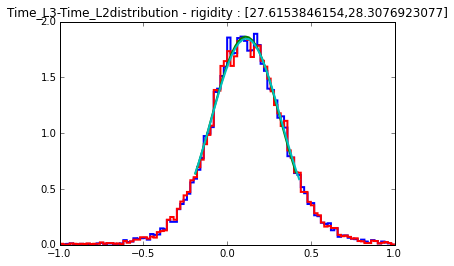

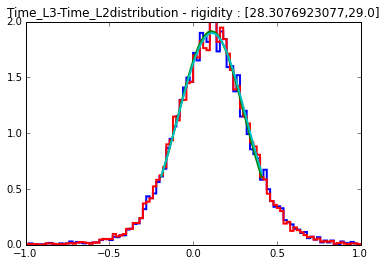

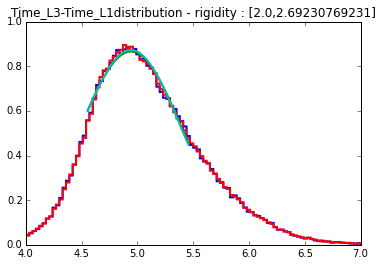

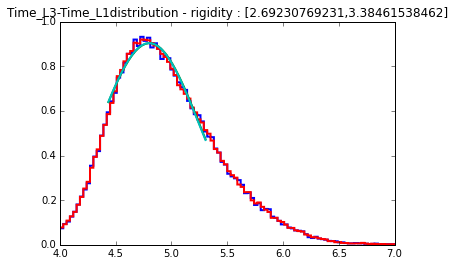

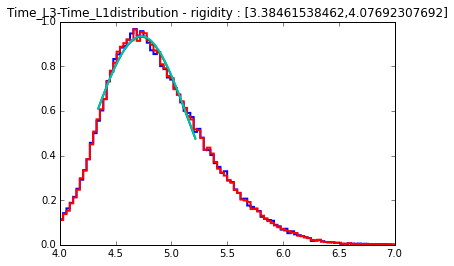

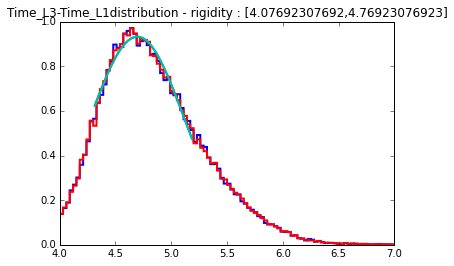

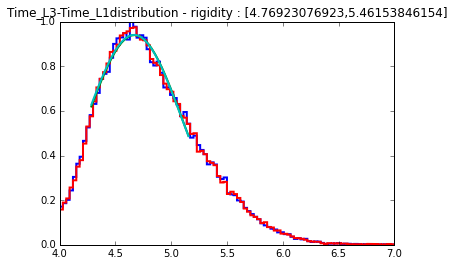

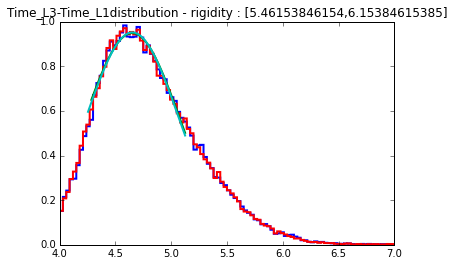

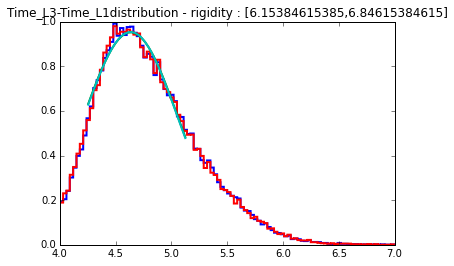

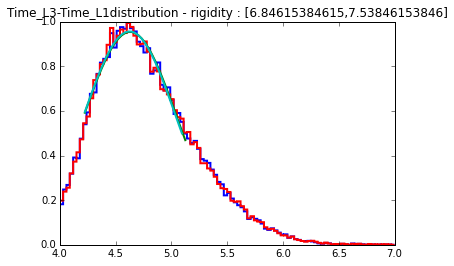

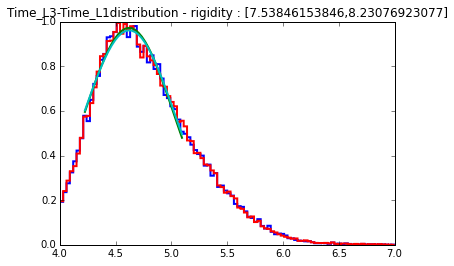

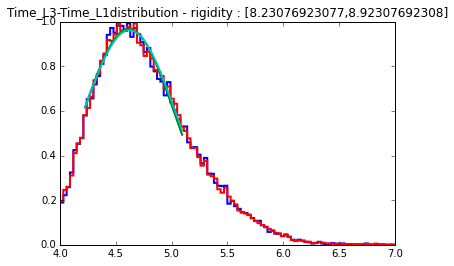

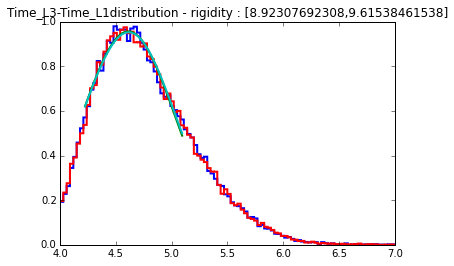

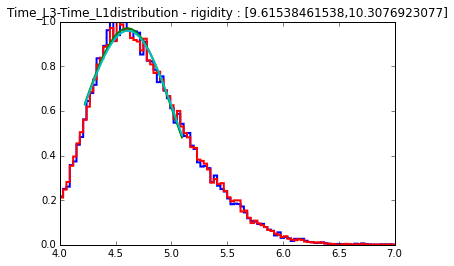

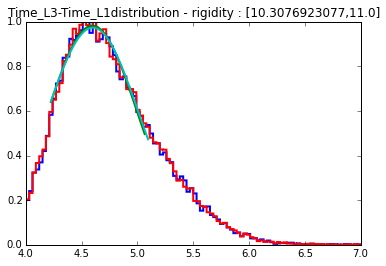

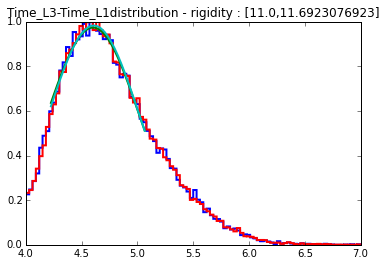

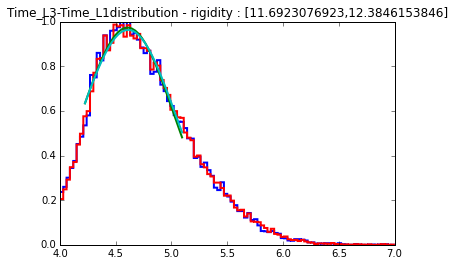

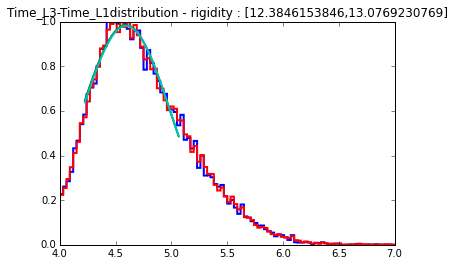

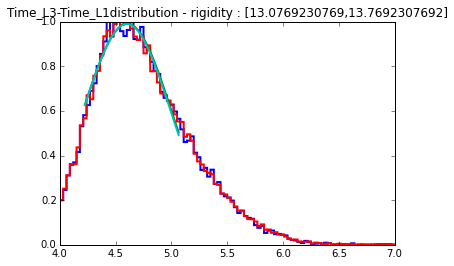

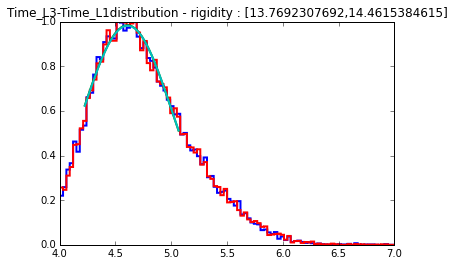

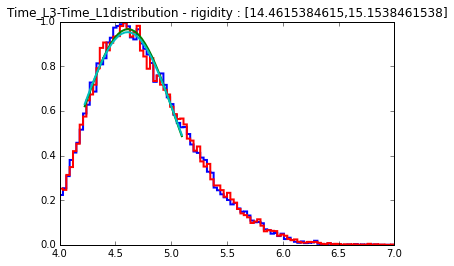

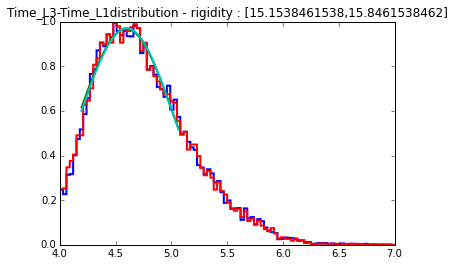

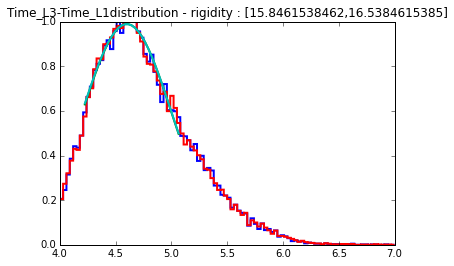

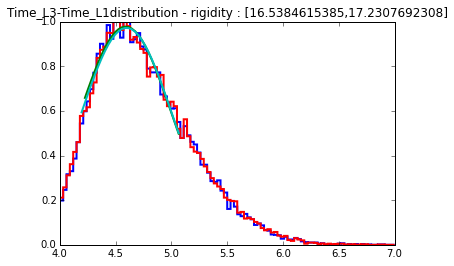

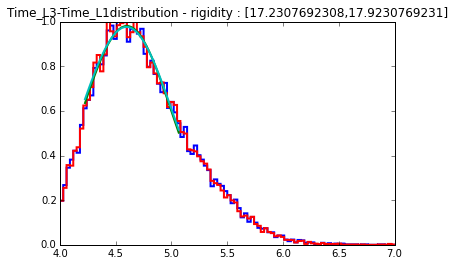

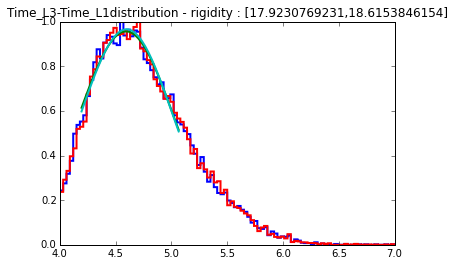

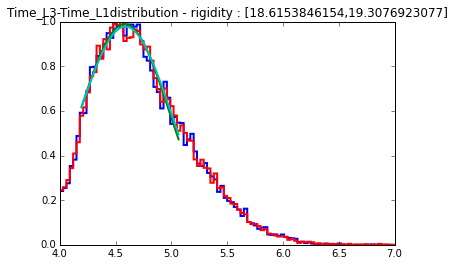

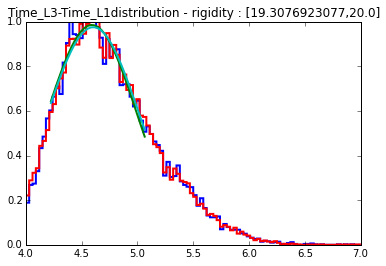

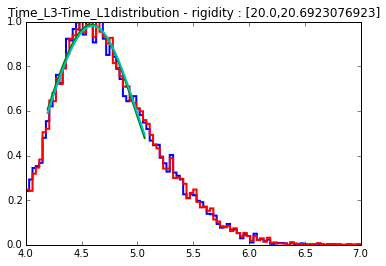

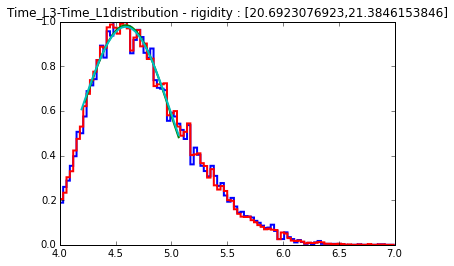

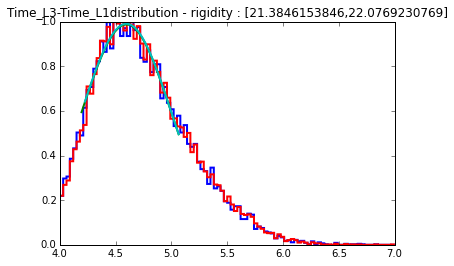

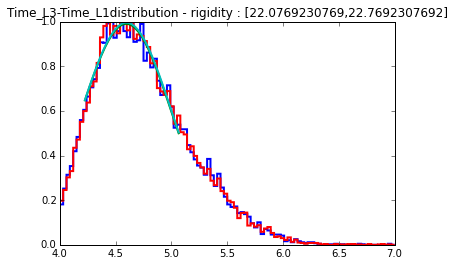

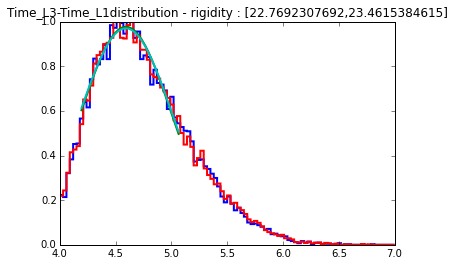

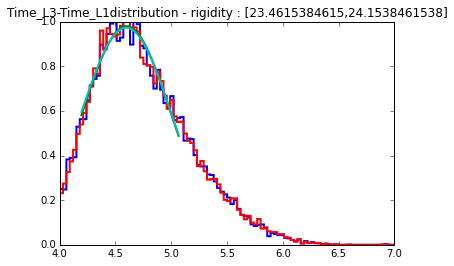

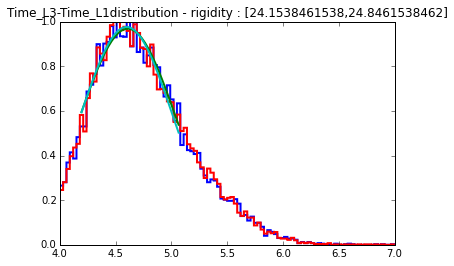

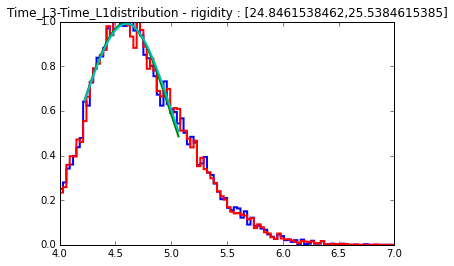

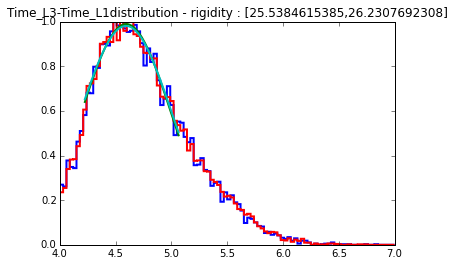

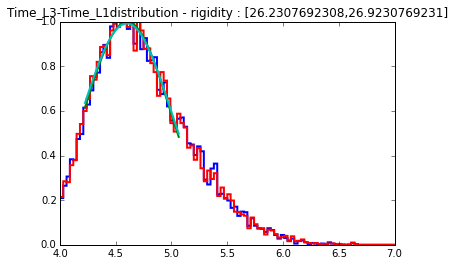

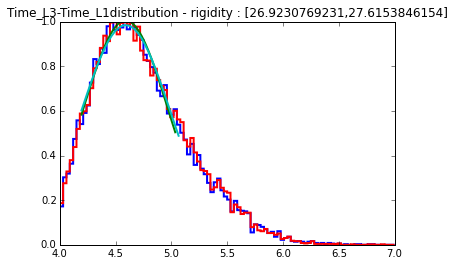

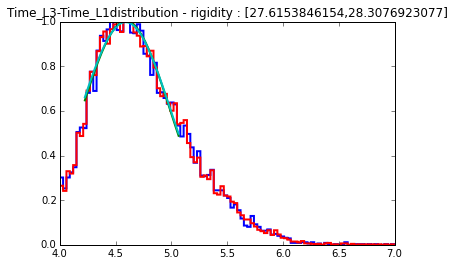

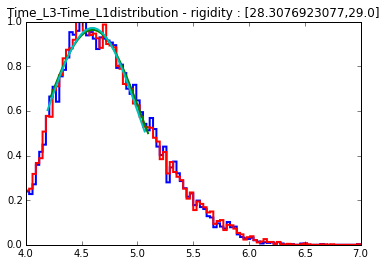

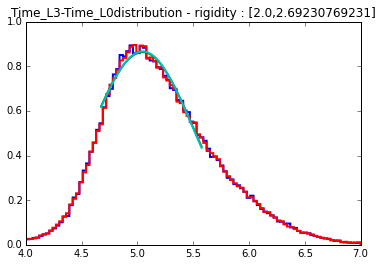

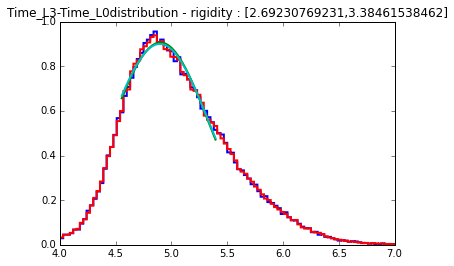

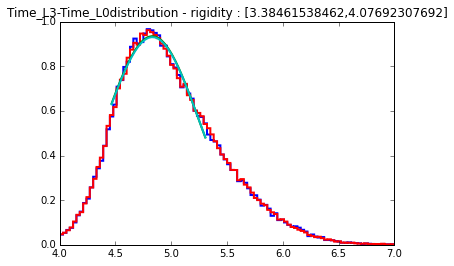

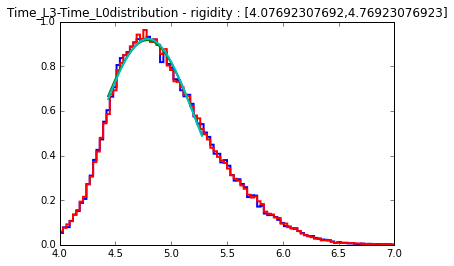

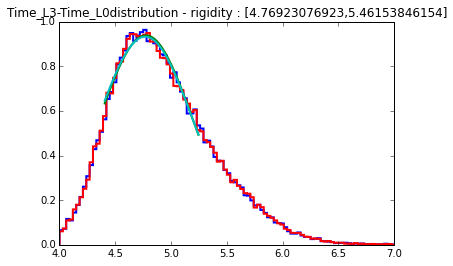

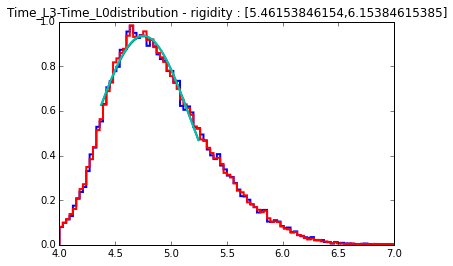

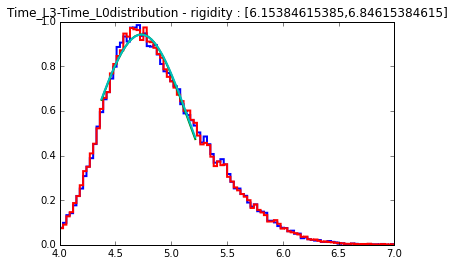

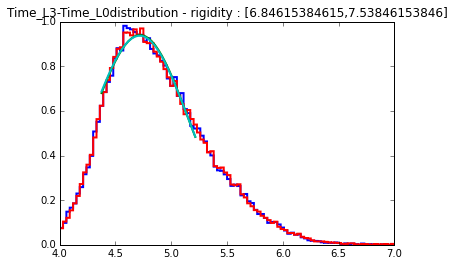

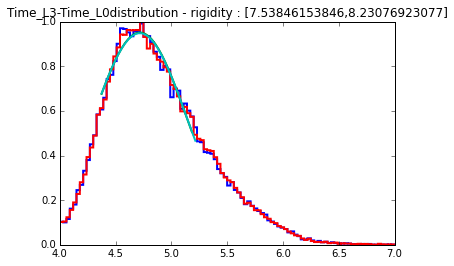

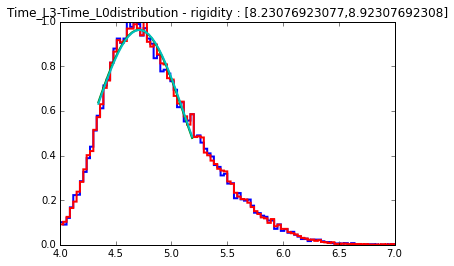

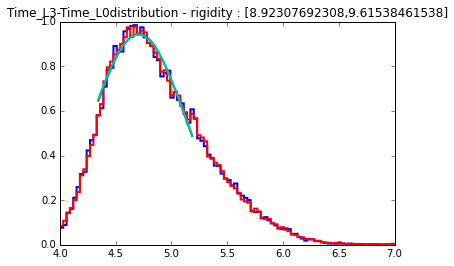

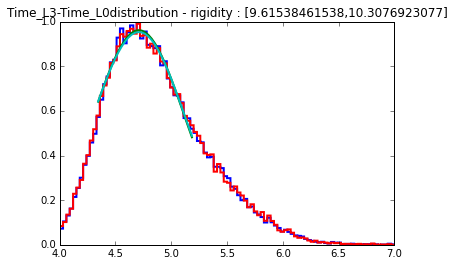

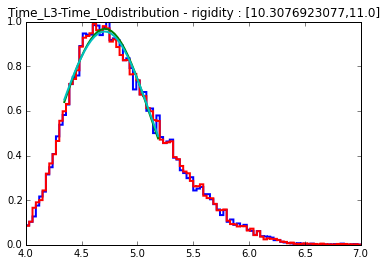

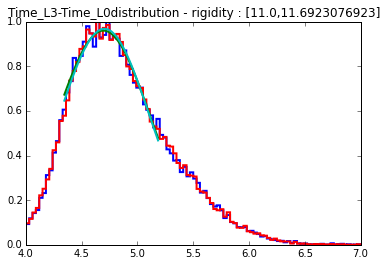

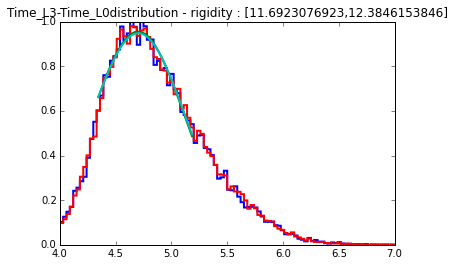

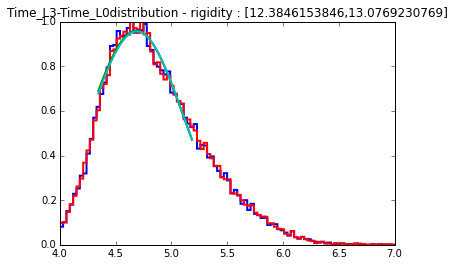

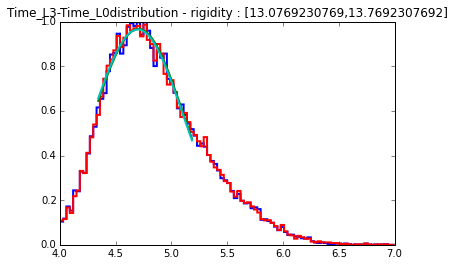

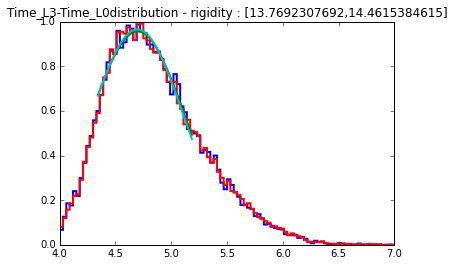

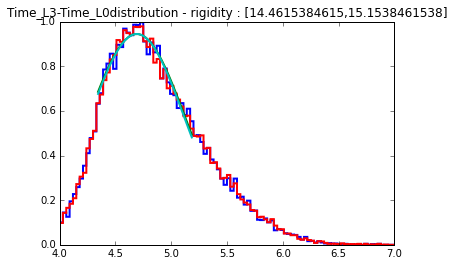

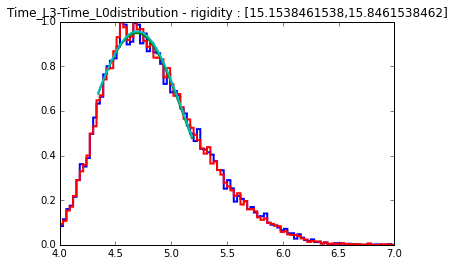

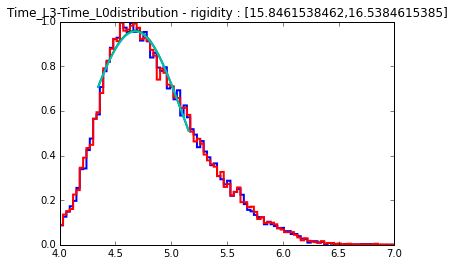

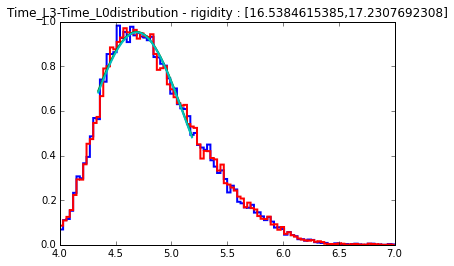

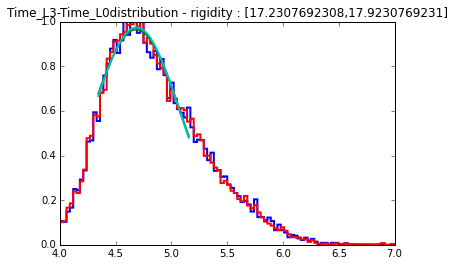

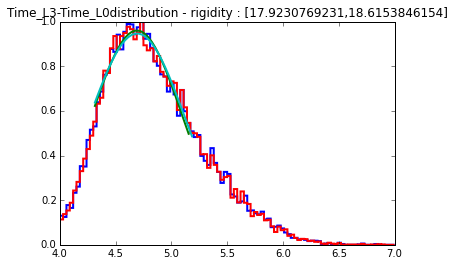

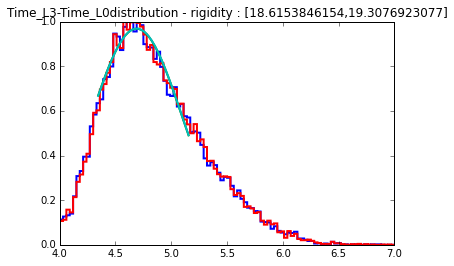

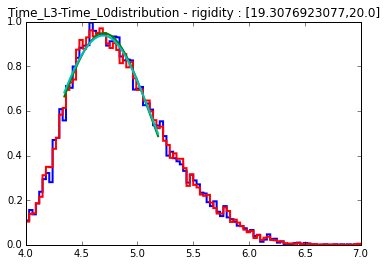

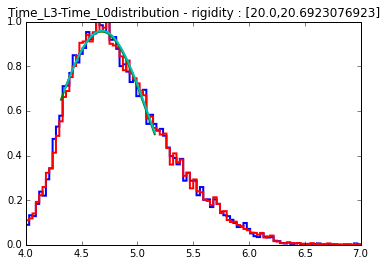

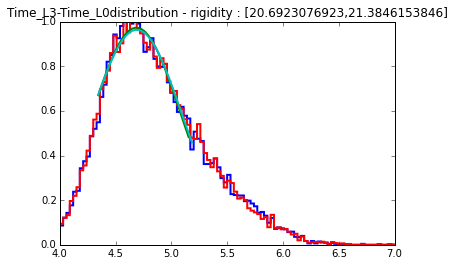

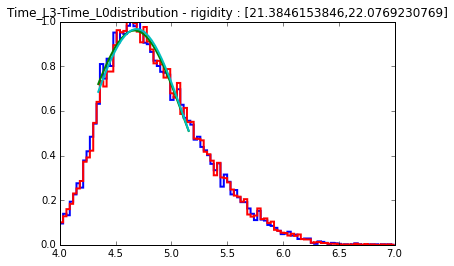

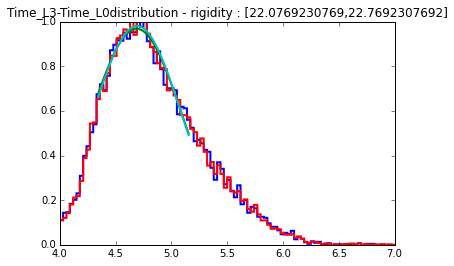

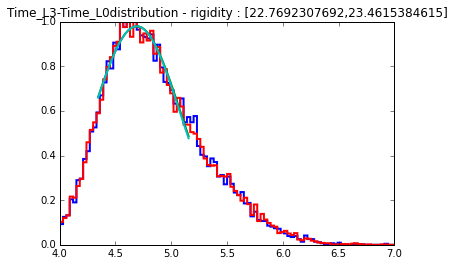

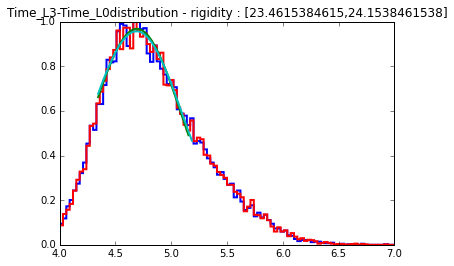

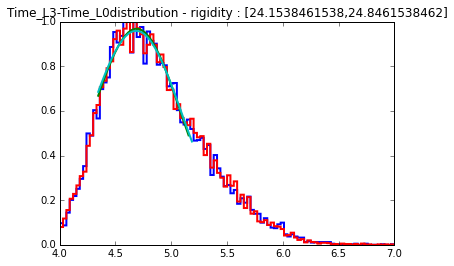

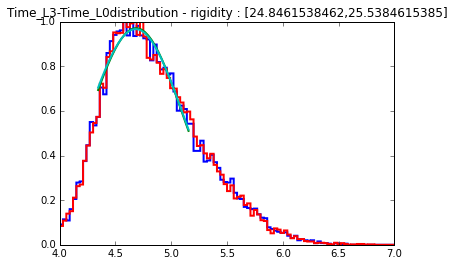

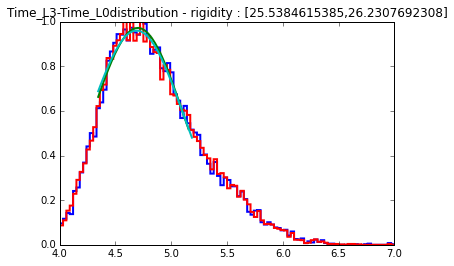

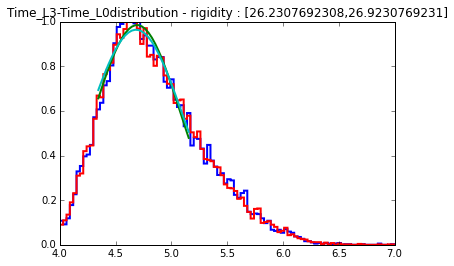

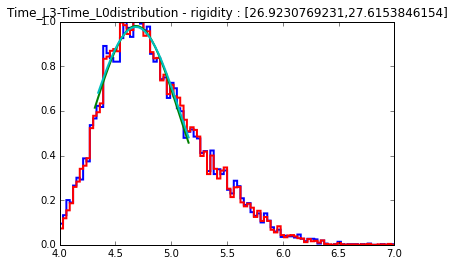

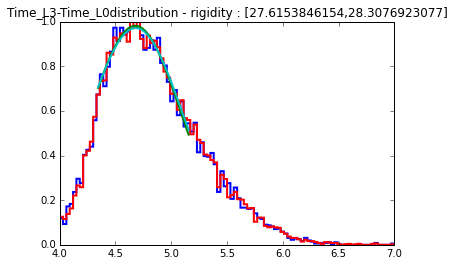

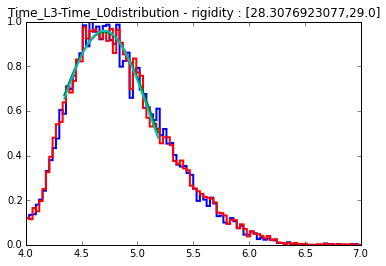

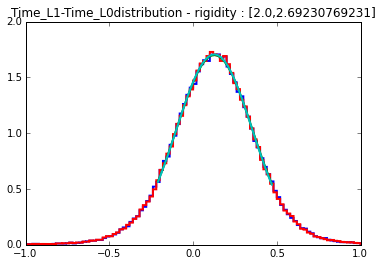

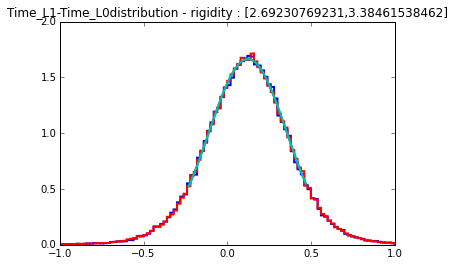

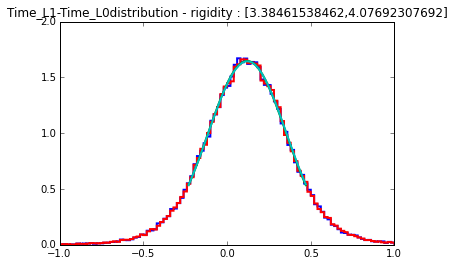

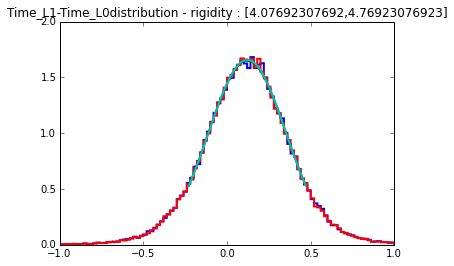

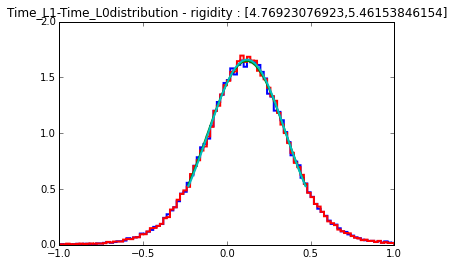

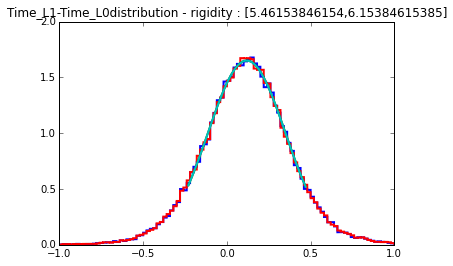

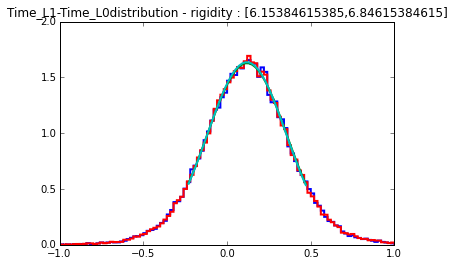

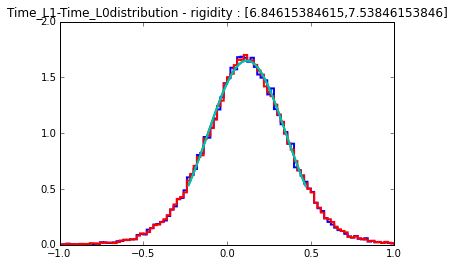

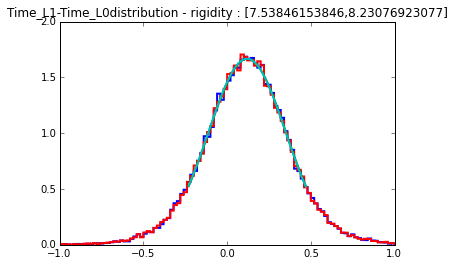

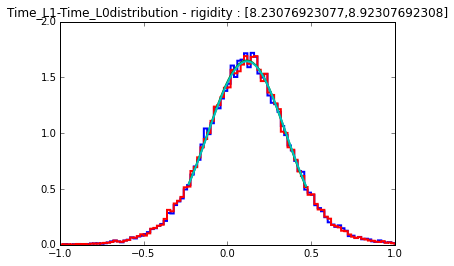

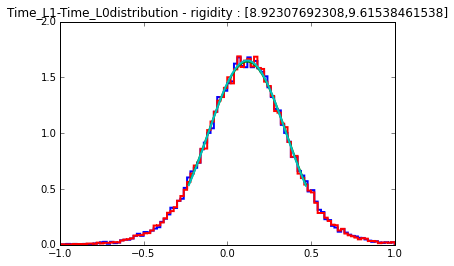

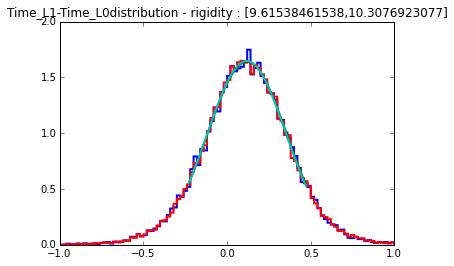

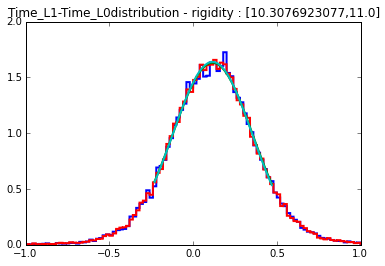

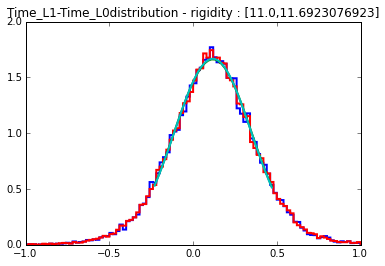

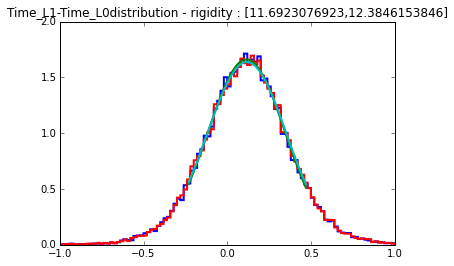

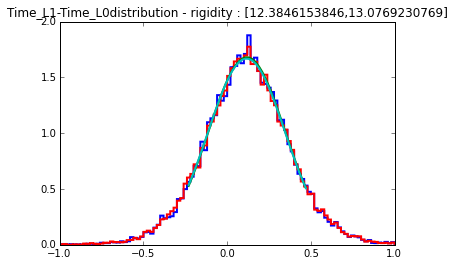

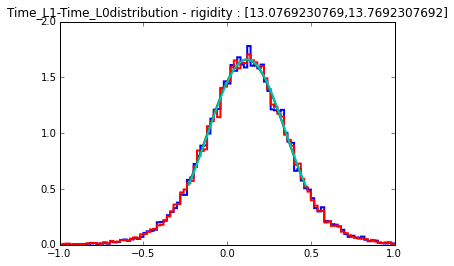

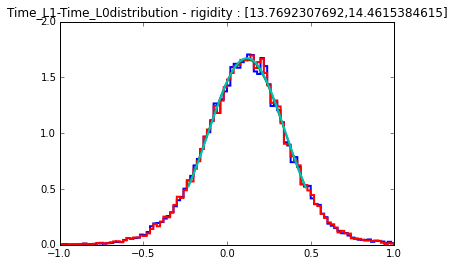

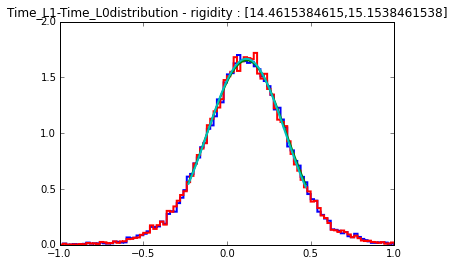

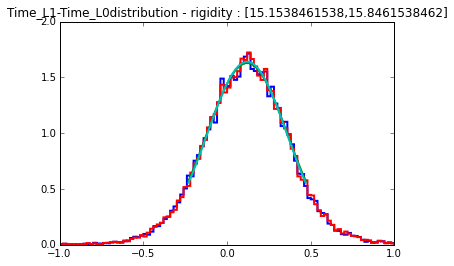

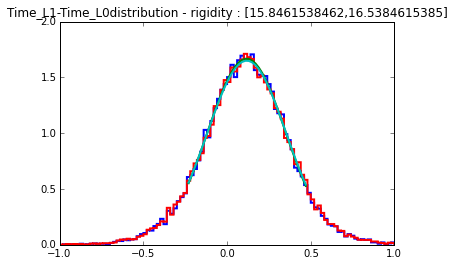

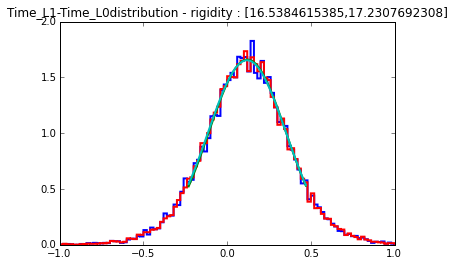

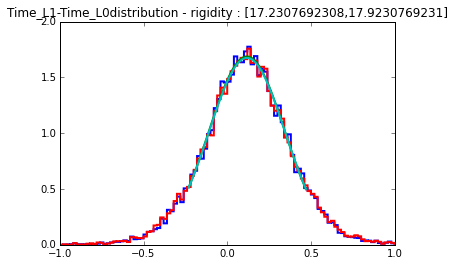

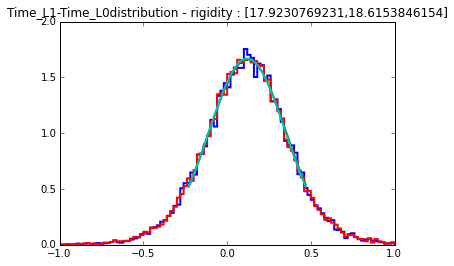

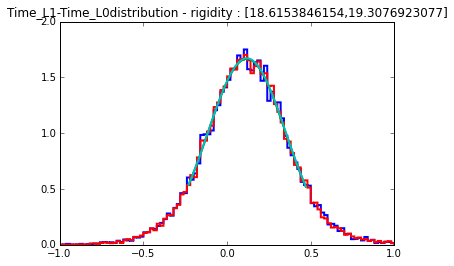

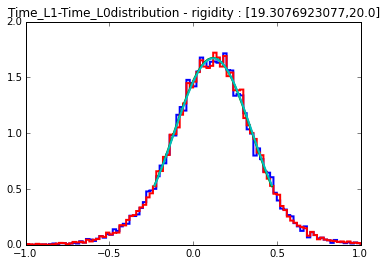

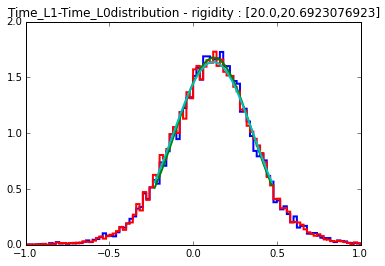

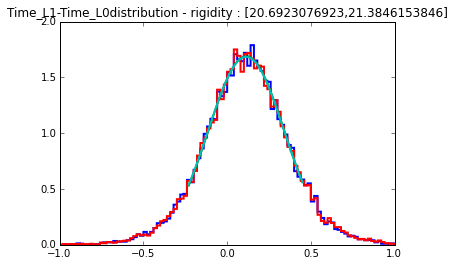

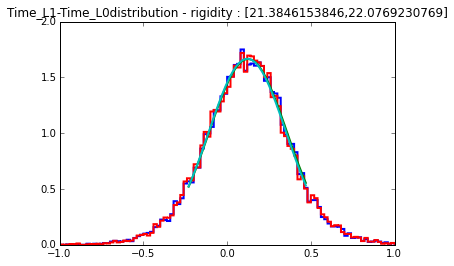

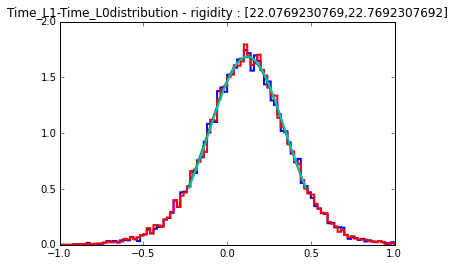

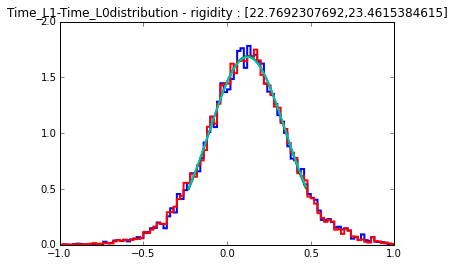

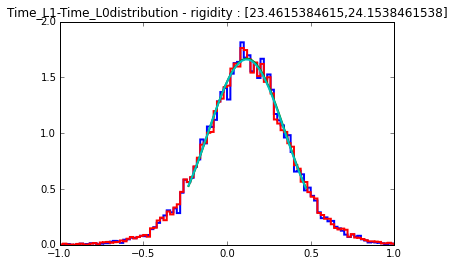

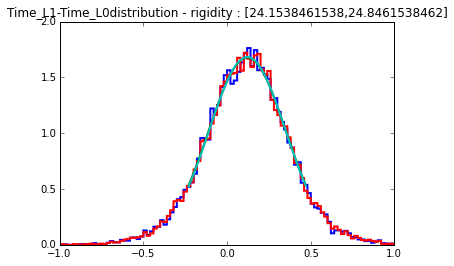

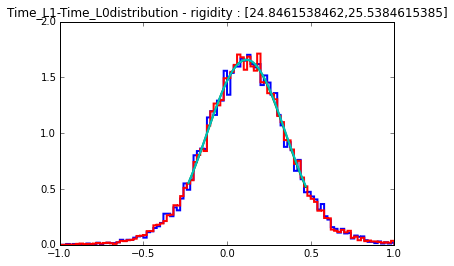

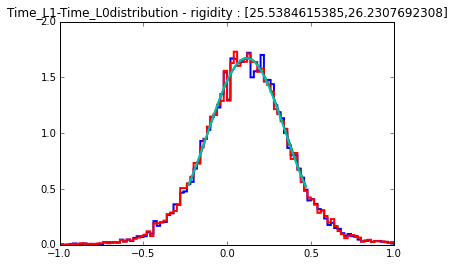

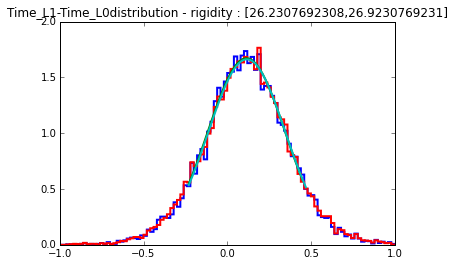

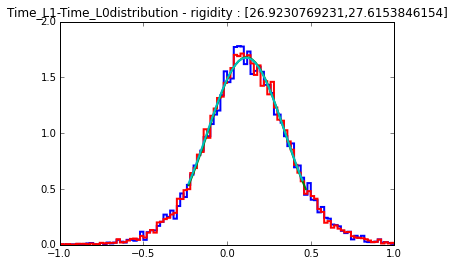

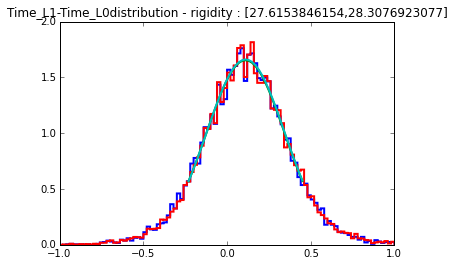

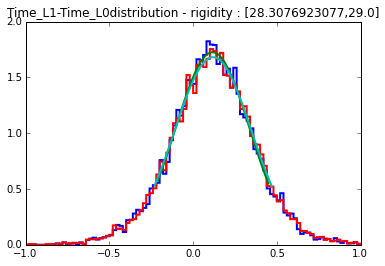

In [13]:
mean = dict()
std = dict()

variables={}
rigBins=np.linspace(2,29,40)
print rigBins

variables['BetaTOFH']=([9.0, 0.95, 0.05], (0.8, 1.1), (0,12), 1)
variables['BetaTOF'] =([9.0, 0.95, 0.05], (0.8, 1.1), (0,12), 1)
variables['Time_L3-Time_L0']=([1.0, 6.0, 1.0], (4,7),(0,1), 1)
variables['Time_L3-Time_L1']=([1.0, 6.0, 1.0], (4,7),(0,1), 1)
variables['Time_L3-Time_L2']=([1.0, 0, 0.5], (-1,1),(0,2), 1.5)
variables['Time_L1-Time_L0']=([1.0, 0, 0.5], (-1,1),(0,2), 1.5)


for var in variables:
    mean[var]=dict()
    std[var]=dict()

for df in [dfData,dfMC]:
    for var in variables:
        scale,mean[var][df.index.name],std[var][df.index.name]=zip(* fitAllRigBin(df,var,rigBins,*variables[var]) )    

BetaTOFH
BetaTOF
Time_L3-Time_L2
Time_L3-Time_L1
Time_L3-Time_L0
Time_L1-Time_L0


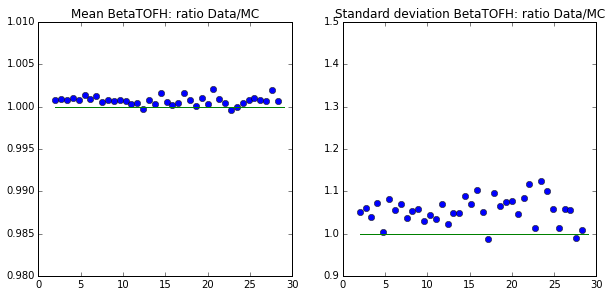

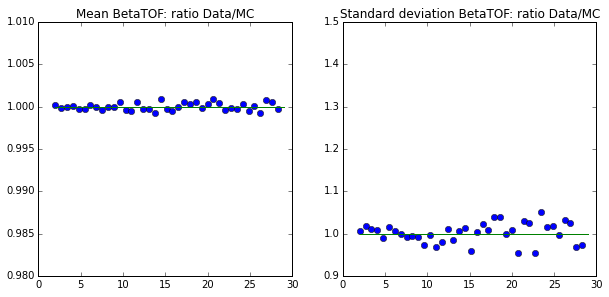

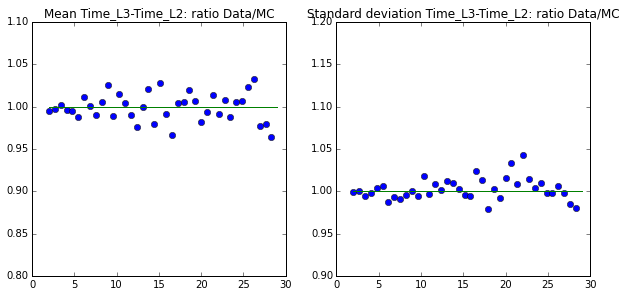

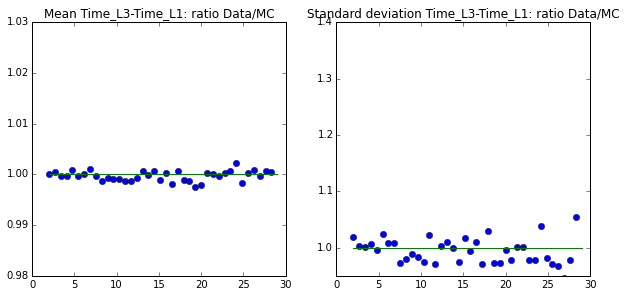

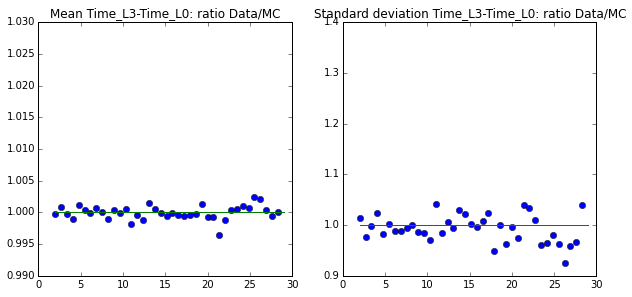

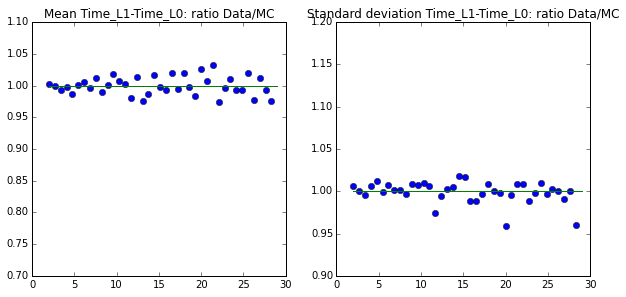

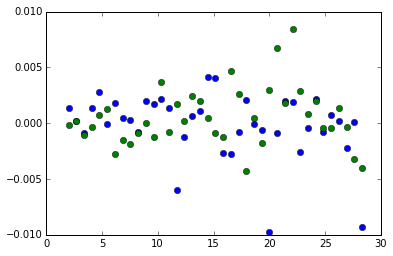

In [14]:
canvasMean={ 'Time_L3-Time_L0':(0.99,1.03),
             'Time_L3-Time_L2':(0.80,1.10),
             'Time_L3-Time_L1':(0.98,1.03),
             'Time_L1-Time_L0':(0.70,1.10),
             'BetaTOFH':          (0.98,1.01),
             'BetaTOF':           (0.98,1.01)}

canvasStd={ 'Time_L3-Time_L0':(0.90,1.40),
            'Time_L3-Time_L2':(0.90,1.20),
            'Time_L3-Time_L1':(0.95,1.40),
            'Time_L1-Time_L0':(0.90,1.20),
            'BetaTOFH':       (0.90,1.50),
            'BetaTOF':          (0.90,1.50)}

for var in variables:
    print var
    figure(figsize=(10,10))
    subplot(221)
    ratioMean=[x/y for x,y in zip(mean[var]['Data'],mean[var]['MC'])]

    plt.title('Mean '+ var + ': ratio Data/MC')
    plt.plot(rigBins[:-1],ratioMean,'o')
    plt.plot((rigBins[0],rigBins[-1]),(1,1))
    ylim(canvasMean[var])

    subplot(222)
    ratioStd=[x/y for x,y in zip(std[var]['Data'],std[var]['MC'])]
    plt.title('Standard deviation '+ var + ': ratio Data/MC')
    plt.plot(rigBins[:-1],ratioStd,'o')
    plt.plot((rigBins[0],rigBins[-1]),(1,1))
    ylim(canvasStd[var])
    

    
figure()    
plt.plot(rigBins[:-1],[x-y for x,y in zip(std['Time_L1-Time_L0']['Data'],std['Time_L1-Time_L0']['MC'])],'o')
plt.plot(rigBins[:-1],[x-y for x,y in zip(std['Time_L3-Time_L2']['Data'],std['Time_L3-Time_L2']['MC'])],'o')


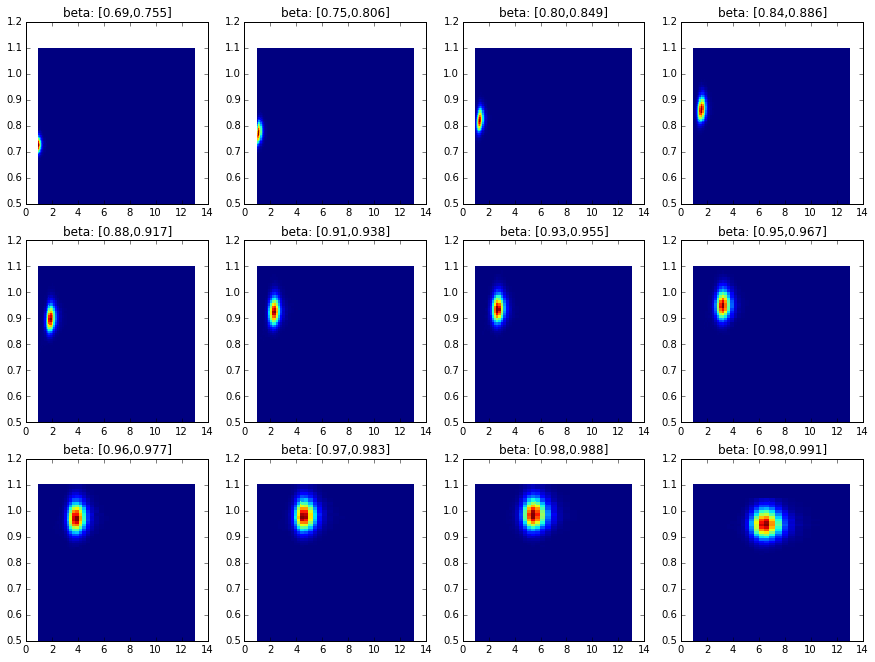

In [34]:
import glob
import pandas as pd
import utils
import matplotlib.pyplot as plt

# proton=glob.glob('/afs/cern.ch/user/b/bcoste/deutons/2.counting/datasets/tofh/*_p_.pd')
# deuton=glob.glob('/afs/cern.ch/user/b/bcoste/deutons/2.counting/datasets/tofh/*_d_.pd')

figure(figsize=(15,15))
for i in range(3,15):
    subplot(4,4,1+i-3)
    df=pd.read_csv('/afs/cern.ch/user/b/bcoste/deutons/2.counting/datasets/tofh/beta_vs_rgdt_GenBin'+str(i)+'_p_.pd')
    plt.title('beta: ['+df.columns[0][9:13]+','+df.columns[0][24:29]+']')
    df=df.set_index(df.columns[0])
    utils.plot_matrix(df)
    df.columns